In [ ]:
import sqlite3
import random
from datetime import datetime, timedelta
from faker import Faker


num_machines = 10
num_orders = 1000
num_errors = 500
num_maintenance = 50

fake = Faker()

with sqlite3.connect("industrial_process.db") as conn:
    cursor = conn.cursor()
    
    cursor.execute("""
    CREATE TABLE IF NOT EXISTS machines (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        name TEXT NOT NULL,
        type TEXT NOT NULL,
        location TEXT NOT NULL,
        status TEXT NOT NULL,
        year INTEGER NOT NULL
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS production_orders (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        product TEXT NOT NULL,
        machine_id INTEGER NOT NULL,
        start_date TEXT NOT NULL,
        end_date TEXT NOT NULL,
        quality_status TEXT NOT NULL,
        FOREIGN KEY (machine_id) REFERENCES machines (id)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS error_logs (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        machine_id INTEGER NOT NULL,
        error_date TEXT NOT NULL,
        description TEXT NOT NULL,
        severity TEXT NOT NULL,
        FOREIGN KEY (machine_id) REFERENCES machines (id)
    )
    """)

    cursor.execute("""
    CREATE TABLE IF NOT EXISTS maintenance_plans (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        machine_id INTEGER NOT NULL,
        scheduled_date TEXT NOT NULL,
        completed_date TEXT,
        technician TEXT NOT NULL,
        FOREIGN KEY (machine_id) REFERENCES machines (id)
    )
    """)

    conn.commit()

with sqlite3.connect("industrial_process.db") as conn:
    cursor = conn.cursor()

    machines = []
    for i in range(1, num_machines + 1):
        machines.append((
            f"Machine-{i:03}",
            fake.random_element(elements=("Schweißroboter", "Fräsmaschine", "Montageroboter")),
            fake.random_element(elements=("Werkhalle A", "Werkhalle B", "Werkhalle C")),
            fake.random_element(elements=("Aktiv", "Wartung", "Defekt")),
            random.randint(2000, 2020)  # Baujahr zwischen 2000 und 2020
        ))
    cursor.executemany("INSERT INTO machines (name, type, location, status, year) VALUES (?, ?, ?, ?, ?)", machines)

    orders = []
    for i in range(1, num_orders + 1):
        machine_id = random.randint(1, num_machines)
        start_date = fake.date_between(start_date="-1y", end_date="today")
        end_date = start_date + timedelta(days=random.randint(1, 10))
        orders.append((
            fake.random_element(elements=("Getriebe", "Motorblock", "Bremssystem")),
            machine_id,
            start_date,
            end_date,
            fake.random_element(elements=("Okay", "Nacharbeit", "Ausschuss"))
        ))
    cursor.executemany("INSERT INTO production_orders (product, machine_id, start_date, end_date, quality_status) VALUES (?, ?, ?, ?, ?)", orders)

    errors = []
    for i in range(1, num_errors + 1):
        machine_id = random.randint(1, num_machines)
        error_date = fake.date_between(start_date="-1y", end_date="today")
        errors.append((
            machine_id,
            error_date,
            fake.random_element(elements=("Überhitzung", "Materialstau", "Sensorfehler")),
            fake.random_element(elements=("Niedrig", "Mittel", "Hoch"))
        ))
    cursor.executemany("INSERT INTO error_logs (machine_id, error_date, description, severity) VALUES (?, ?, ?, ?)", errors)

    maintenance = []
    for i in range(1, num_maintenance + 1):
        machine_id = random.randint(1, num_machines)
        scheduled_date = fake.date_between(start_date="-1y", end_date="today")
        completed_date = scheduled_date + timedelta(days=random.randint(1, 7)) if random.choice([True, False]) else None
        maintenance.append((
            machine_id,
            scheduled_date,
            completed_date,
            fake.name()
        ))
    cursor.executemany("INSERT INTO maintenance_plans (machine_id, scheduled_date, completed_date, technician) VALUES (?, ?, ?, ?)", maintenance)

    conn.commit()

In [ ]:
from langchain_openai import ChatOpenAI, OpenAIEmbeddings


## Uncomment the following lines to initialize the LLM and embeddings
# llm = ChatOpenAI(

# )

# embeddings = OpenAIEmbeddings(

# )

In [3]:
import sqlite3


distinct_value_table_columns = {
    "machines": ["name", "type", "location", "status"],
    "production_orders": ["product", "quality_status"],
    "error_logs": ["description", "severity"],
    "maintenance_plans": ["technician"],
}

distinc_table_column_values = {}
with sqlite3.connect("industrial_process.db") as conn:
    cursor = conn.cursor()
    for table, columns in distinct_value_table_columns.items():
        for column in columns:
            cursor.execute(f"SELECT DISTINCT {column} FROM {table}")
            distinct_column_values = distinc_table_column_values.get(table, {})
            distinct_values = distinct_column_values.get(column, set())
            for row in cursor.fetchall():
                distinct_values.add(row[0])
            distinct_column_values[column] = distinct_values
            distinc_table_column_values[table] = distinct_column_values

In [4]:
from typing import Annotated, TypedDict, Optional, Union, List, Dict, Any

from pydantic import BaseModel

from langchain_core.callbacks import CallbackManagerForToolRun
from langchain_core.tools import BaseTool
from langchain_core.tools.base import ArgsSchema
from langchain_core.retrievers import BaseRetriever


class RetrieverToolInput(BaseModel):
    value: Annotated[str, "Approximate spelling of the value to filter on."]


class RetrieverTool(BaseTool):
    name: str = "search_column_values"
    description: str = (
        "Used to look up values to filter on. Input is an approximate spelling "
        "of the the proper value, output is the valid proper value as well as "
        "the table and the column. Use the value most similar to the search."
    )
    args_schema: Optional[ArgsSchema] = RetrieverToolInput
    return_direct: bool = False
    retriever: Optional[BaseRetriever] = None

    def __init__(self, retriever):
        super().__init__()
        self.retriever = retriever

    def _run(
        self, value: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> Union[List[Dict], None]:
        """Conduct a search."""
        documents = self.retriever.invoke(value)
        return "\n".join(
            [
                f"Correct value: {document.page_content}, Table: {document.metadata['table']}, Column: {document.metadata['column']}"
                for document in documents
            ]
        )

In [5]:
from langchain_community.utilities import SQLDatabase
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain.agents.agent_toolkits import create_retriever_tool
from langchain_core.vectorstores import InMemoryVectorStore


## Parameters
TOP_K_QUERY = 3
TOP_K_RETIREVAL = 2

## Set up the agent
# Database tool
db = SQLDatabase.from_uri("sqlite:///industrial_process.db")
toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

# Retriever tool
vector_store = InMemoryVectorStore(embeddings)
# Populate the vector store with distinct values from the database
for table, distinc_column_values in distinc_table_column_values.items():
    for column, values in distinc_column_values.items():
        vector_store.add_texts(
            texts=list(values),
            metadatas=[{"table": table, "column": column}] * len(values),
            ids=[f"{table}_{column}_{idx}" for idx in range(len(values))],
        )
retriever = vector_store.as_retriever(search_kwargs={"k": TOP_K_RETIREVAL})
retriever_tool = RetrieverTool(retriever=retriever)
tools.append(retriever_tool)

# Define the system message
system_prompt = """You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step. Then you should query the schema of the most 
relevant tables.

If you need to filter on a column value, you must ALWAYS first look up the 
filter value using the `search_column_values` tool, which will return the 
correct value to filter on as well as the table and the column. After this, you
should use the correct value in your query. ALWAYS continue after retrieving
the correct value, do not stop the execution of the agent.

You should ALWAYS answer the question. In your answer, you should ALWAYS use 
the language of the question, so if the
question is in English, you should answer in English, if the question is in 
German, you should answer in German, etc. Translate the values fetched from the 
database if necessary.

Keep your answer short, concise and to the point, but provide enough detail to 
answer the question

""".format(
    dialect=db.dialect,
    top_k=TOP_K_QUERY,
)

# Define the agent
memory = MemorySaver()
agent = create_react_agent(
    model=llm, tools=tools, prompt=system_prompt, checkpointer=memory
)

In [6]:
for tool in tools:
    print(tool.name)
    print(tool.description)
    print(tool.args)
    print(tool.return_direct)
    print("--------------------------------------")

sql_db_query
Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.
{'query': {'description': 'A detailed and correct SQL query.', 'title': 'Query', 'type': 'string'}}
False
--------------------------------------
sql_db_schema
Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3
{'table_names': {'description': "A comma-separated list of the table names for which to return the schema. Example input: 'table1, table2, table3'", 'title': 'Table Names', 'type': 'string'}}
False
--------------------------------------
sql_db_li

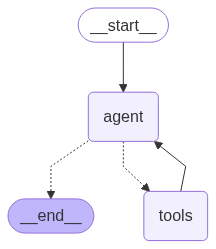

In [7]:
from IPython.display import Image, display


display(Image(agent.get_graph().draw_mermaid_png()))

In [8]:
from langchain_core.messages.tool import ToolMessage


def get_last_query(messages):
    for message in reversed(messages):
        if isinstance(message, ToolMessage) and message.name == "sql_db_query_checker":
            return message.content

In [9]:
config = {"configurable": {"thread_id": "1"}}

question = "Welche Maschinen hatten in den letzten drei Monaten die meisten Probleme?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Kannst Du mir die häufigsten Probleme der Maschinen mit den meisten Fehlern nennen?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Wie lange war die Maschine aufgrund dieser Fehler außer Betrieb?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

User: Welche Maschinen hatten in den letzten drei Monaten die meisten Probleme?
Query: ```sql
SELECT m.name, COUNT(e.id) AS problem_count
FROM error_logs e
JOIN machines m ON e.machine_id = m.id
WHERE e.error_date >= date('now', '-3 months')
GROUP BY m.name
ORDER BY problem_count DESC
LIMIT 3;
```
LLM: In den letzten drei Monaten hatten die folgenden Maschinen die meisten Probleme:
1. Machine-009 (17 Probleme)
2. Machine-008 (17 Probleme)
3. Machine-002 (14 Probleme)
User: Kannst Du mir die häufigsten Probleme der Maschinen mit den meisten Fehlern nennen?
Query: ```sql
SELECT description, COUNT(id) AS count
FROM error_logs
WHERE machine_id = 2
GROUP BY description
ORDER BY count DESC
LIMIT 3;
```
LLM: Die häufigsten Probleme der Maschinen mit den meisten Fehlern sind:

- Machine-009: Materialstau, Überhitzung, Sensorfehler
- Machine-008: Überhitzung, Sensorfehler, Materialstau
- Machine-002: Sensorfehler, Materialstau, Überhitzung

Diese Probleme treten jeweils am häufigsten bei den ge

In [10]:
config = {"configurable": {"thread_id": "6"}}

question = "Welche Produktionsaufträge hatten in den letzten sechs Monaten die höchste Ausschussquote?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Welche Maschinen wurden für den Auftrag mit der höchsten Ausschussquote verwendet, und gab es dort bekannte Fehler?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Wie hat sich dieser Fehler auf die Produktionszeit ausgewirkt?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

User: Welche Produktionsaufträge hatten in den letzten sechs Monaten die höchste Ausschussquote?
Query: ```sql
SELECT id, product, start_date, end_date, quality_status
FROM production_orders
WHERE end_date >= date('now', '-6 months')
ORDER BY CASE WHEN quality_status = 'Ausschuss' THEN 1 ELSE 0 END DESC, end_date DESC
LIMIT 3;
```
LLM: Die Produktionsaufträge mit der höchsten Ausschussquote in den letzten sechs Monaten waren:

1. Auftrag 641: Produkt "Bremssystem", Zeitraum 30.06.2025 – 09.07.2025, Status "Ausschuss"
2. Auftrag 517: Produkt "Bremssystem", Zeitraum 29.06.2025 – 08.07.2025, Status "Ausschuss"
3. Auftrag 263: Produkt "Motorblock", Zeitraum 26.06.2025 – 06.07.2025, Status "Ausschuss"

Alle diese Aufträge hatten den Status "Ausschuss".
User: Welche Maschinen wurden für den Auftrag mit der höchsten Ausschussquote verwendet, und gab es dort bekannte Fehler?
Query: SELECT error_date, description, severity FROM error_logs WHERE machine_id = 7 ORDER BY error_date DESC LIMIT 3;
L

In [11]:
config = {"configurable": {"thread_id": "9"}}

question = "Welche Maschinen haben geplante Wartungen in den letzten drei Monaten nicht durchgeführt?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Gab es Fehler oder Ausfälle bei diesen Maschinen nach den geplanten, aber nicht durchgeführten Wartungen?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

question = "Wie lange waren diese Maschinen aufgrund der Fehler außer Betrieb, und wie hat sich das auf die Produktionsaufträge ausgewirkt?"
print(f"User: {question}")
response = agent.invoke(input={"messages": [{"role": "user", "content": question}]}, config=config)
query = get_last_query(response["messages"])
print(f"Query: {query}")
answer = response["messages"][-1].content
print(f"LLM: {answer}")

User: Welche Maschinen haben geplante Wartungen in den letzten drei Monaten nicht durchgeführt?
Query: ```sql
SELECT m.name, m.type, m.location, mp.scheduled_date
FROM machines m
JOIN maintenance_plans mp ON m.id = mp.machine_id
WHERE mp.scheduled_date >= date('now', '-3 months')
  AND (mp.completed_date IS NULL OR mp.completed_date = '')
LIMIT 3;
```
LLM: Folgende Maschinen haben geplante Wartungen in den letzten drei Monaten nicht durchgeführt:
- Machine-001 (Fräsmaschine, Werkhalle B), geplant am 14.05.2025
- Machine-006 (Fräsmaschine, Werkhalle C), geplant am 23.05.2025
- Machine-002 (Montageroboter, Werkhalle B), geplant am 06.06.2025
User: Gab es Fehler oder Ausfälle bei diesen Maschinen nach den geplanten, aber nicht durchgeführten Wartungen?
Query: ```sql
SELECT m.name, e.error_date, e.description, e.severity
FROM machines m
JOIN error_logs e ON m.id = e.machine_id
WHERE (m.name = 'Machine-001' AND e.error_date > '2025-05-14')
   OR (m.name = 'Machine-006' AND e.error_date > '2

In [12]:
config = {"configurable": {"thread_id": "4"}}

question = "Wie viele Probleme gab es mit Machine-027 und welche?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
    config=config,
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Wie viele Probleme gab es mit Machine-027 und welche?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (call_zs7en5z64Gcg6QWiSw18lLeu)
 Call ID: call_zs7en5z64Gcg6QWiSw18lLeu
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

error_logs, machines, maintenance_plans, production_orders
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema (call_dGMH3Rsazco0pcTmbhEtBRqt)
 Call ID: call_dGMH3Rsazco0pcTmbhEtBRqt
  Args:
    table_names: machines, error_logs
================================= Tool Message =================================
Name: sql_db_schema


CREATE TABLE error_logs (
	id INTEGER, 
	machine_id INTEGER NOT NULL, 
	error_date TEXT NOT NULL, 
	description TEXT NOT NULL, 
	severity TEXT NOT NULL, 
	PRI